In [23]:
# import necessary libraries and specify that graphs should be plotted inline. 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import neighbors, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import roc_curve,auc
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

### Data Exploration

In [24]:
#load dataset
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
df = pd.DataFrame(np.c_[breast_cancer['target'], breast_cancer['data']], columns=np.append(['MB'],breast_cancer['feature_names']))

# diagnosis
df['MB'] = df['MB'].replace('M',1) # M = malignant
df['MB'] = df['MB'].replace('B',0) # B = benign
df

,MB,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,0.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,0.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,0.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,0.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.0,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,0.0,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,0.0,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,0.0,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [25]:
n_samples, n_features = breast_cancer.data.shape
print ('The dimensions of the data set are', n_samples, 'by', n_features)
print('The classes are: ', breast_cancer.target_names)
print('The features in the data set are:', breast_cancer.feature_names)

The dimensions of the data set are 569 by 30
The classes are:  ['malignant' 'benign']
The features in the data set are: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [26]:
# Top3 Highest-correlated features
corr_matrix = df.corr()
top3_features = abs(corr_matrix['MB']).sort_values(ascending=False)[1:4]
top3_features 

worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
Name: MB, dtype: float64

## Decision tree

In [27]:
x = breast_cancer.data
y = breast_cancer.target

# Split the dataset into training(70%) and testing(30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3)

# Cross Validation for inner and outer loop
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
# Tuning hyperparameters
criterions = ['gini', 'entropy']
d_rng =  list(range(1,10)) # max_depth
s_rng = list(range(2,10)) # min_samples_split
t_grid = dict(criterion = criterions,max_depth = d_rng,min_samples_split = s_rng)

# model
tree = DecisionTreeClassifier()

# non-nested parameter search and scoring
tree_grid = GridSearchCV(tree, t_grid, cv=inner_cv, scoring='accuracy')

# train the model
tree_grid.fit(X_train, y_train)
y_pred = tree_grid.predict(X_test)

# nested CV with parameter opitimization
tree_score = cross_val_score(tree_grid,X=x,y=y, cv=outer_cv)

In [29]:
# Evaluate performance by cross-validation
tree_acc_scores = accuracy_score(y_test, y_pred)
tree_conf_mtrx = confusion_matrix(y_test, y_pred)
tree_cfr = classification_report(y_test, y_pred)


print('Predictive accuracy:', tree_acc_scores)
print('\n')
print('Confusion matrix: \n', tree_conf_mtrx)
print('\n')
print('Classification report:''\n', tree_cfr)

# aggregated performance metrics 
print("Mean of cross validation scores: ",tree_score.mean())
print("Standard Deviation of cross validation scores: ",tree_score.std())

Predictive accuracy: 0.9122807017543859


Confusion matrix: 
 [[65  7]
 [ 8 91]]


Classification report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90        72
           1       0.93      0.92      0.92        99

    accuracy                           0.91       171
   macro avg       0.91      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171

Mean of cross validation scores:  0.9507685142058687
Standard Deviation of cross validation scores:  0.0106545704601476


The AUC is:  0.9109848484848485
The kappa stats is:  0.8204158790170133
The MCC stats is:  0.8204746826421807


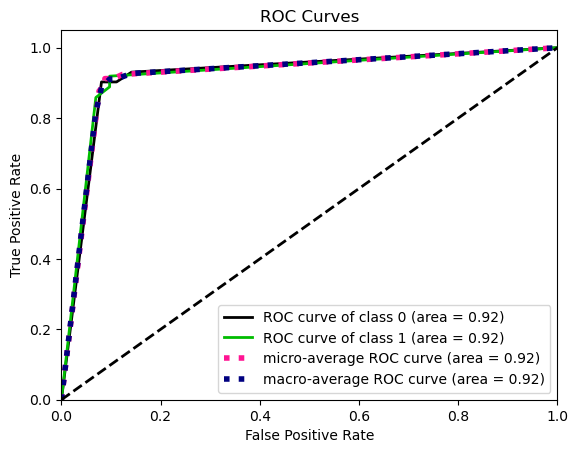

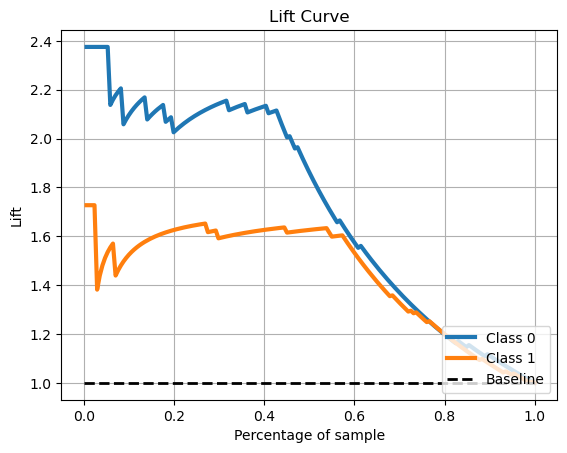

In [30]:
# AUC
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("The AUC is: ", auc)
print("The kappa stats is: ", cohen_kappa_score(y_test, y_pred))
print("The MCC stats is: ", matthews_corrcoef(y_test, y_pred))

# ROC curve
predicted_probas_tree = tree_grid.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas_tree)

# Lift curve
skplt.metrics.plot_lift_curve(y_test, predicted_probas_tree)
plt.show()

## K-nearest Neighbors

In [31]:
# Standardize the features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [32]:
# Tuning hyperparameters
weights = ['uniform', 'distance']
k_values = list(range(1,30))
k_grid = dict(weights = weights,n_neighbors = k_values)

# model
knn = KNeighborsClassifier()

# non-nested parameter search and scoring
knn_grid = GridSearchCV(knn, k_grid, cv=inner_cv, scoring='accuracy')

# train the model
knn_grid.fit(X_train_normalized, y_train)
y_pred = knn_grid.predict(X_test_normalized)

# nested CV with parameter opitimization
knn_score = cross_val_score(knn_grid,X=x,y=y, cv=outer_cv)

In [33]:
# Evaluate performance by cross-validation
knn_acc_scores = accuracy_score(y_test, y_pred)
knn_conf_mtrx = confusion_matrix(y_test, y_pred)
knn_cfr = classification_report(y_test, y_pred)


print('Predictive accuracy:', knn_acc_scores)
print('\n')
print('Confusion matrix: \n', knn_conf_mtrx)
print('\n')
print('Classification report:''\n', knn_cfr)

# aggregated performance metrics 
print("Mean of cross validation scores: ",knn_score.mean())
print("Standard Deviation of cross validation scores: ",knn_score.std())

Predictive accuracy: 0.9473684210526315


Confusion matrix: 
 [[64  8]
 [ 1 98]]


Classification report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93        72
           1       0.92      0.99      0.96        99

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Mean of cross validation scores:  0.9296537804688713
Standard Deviation of cross validation scores:  0.0389520409036087


The AUC is:  0.9393939393939393
The kappa stats is:  0.8905950095969289
The MCC stats is:  0.8938369268354494


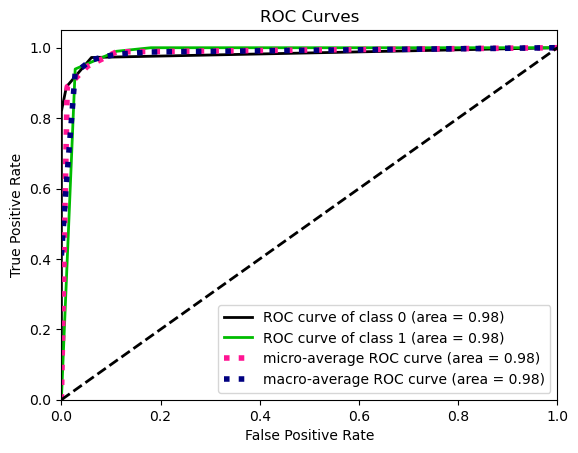

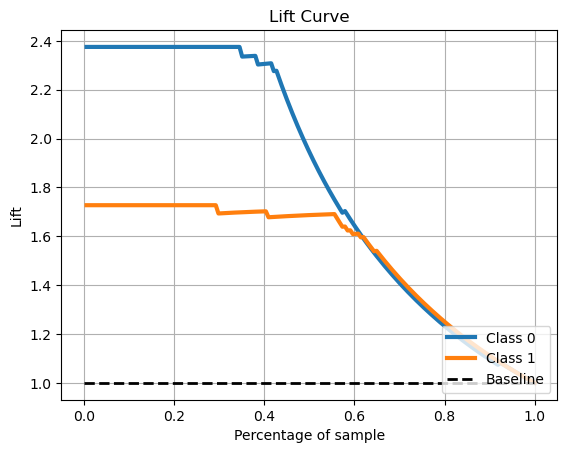

In [34]:
# AUC
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("The AUC is: ", auc)
print("The kappa stats is: ", cohen_kappa_score(y_test, y_pred))
print("The MCC stats is: ", matthews_corrcoef(y_test, y_pred))

# ROC curve
predicted_probas_knn = knn_grid.predict_proba(X_test_normalized)
skplt.metrics.plot_roc(y_test, predicted_probas_knn)

# Lift curve
skplt.metrics.plot_lift_curve(y_test, predicted_probas_knn)
plt.show()

## Logistic Regression

In [35]:
# Standardize the features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [36]:
# Tuning hyperparameters
penalty = ['l1', 'l2', 'elasticnet']
c_values = [10**i for i in range(-5,9)]
l_grid = dict(penalty = penalty, C = c_values)

# model
lg = LogisticRegression()

# non-nested parameter search and scoring
lg_grid = GridSearchCV(lg, l_grid, cv = inner_cv, scoring = 'accuracy')

# train the model
lg_grid.fit(X_train_normalized, y_train)
y_pred = lg_grid.predict(X_test_normalized)

# nested CV with parameter opitimization
lg_score = cross_val_score(lg_grid, X=x, y=y, cv=outer_cv)

In [37]:
# Evaluate performance by cross-validation
lg_acc_scores = accuracy_score(y_test, y_pred)
lg_conf_mtrx = confusion_matrix(y_test, y_pred)
lg_cfr = classification_report(y_test, y_pred)


print('Predictive accuracy:', lg_acc_scores)
print('\n')
print('Confusion matrix: \n', lg_conf_mtrx)
print('\n')
print('Classification report:''\n', lg_cfr)

# aggregated performance metrics 
print("Mean of cross validation scores: ",lg_score.mean())
print("Standard Deviation of cross validation scores: ",lg_score.std())

Predictive accuracy: 0.9649122807017544


Confusion matrix: 
 [[67  5]
 [ 1 98]]


Classification report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96        72
           1       0.95      0.99      0.97        99

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171

Mean of cross validation scores:  0.947228691197019
Standard Deviation of cross validation scores:  0.030508905827995994


The AUC is:  0.9602272727272729
The kappa stats is:  0.9274809160305344
The MCC stats is:  0.928566739502216


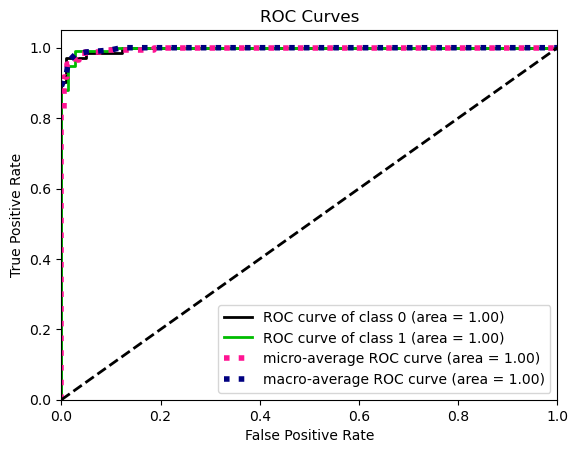

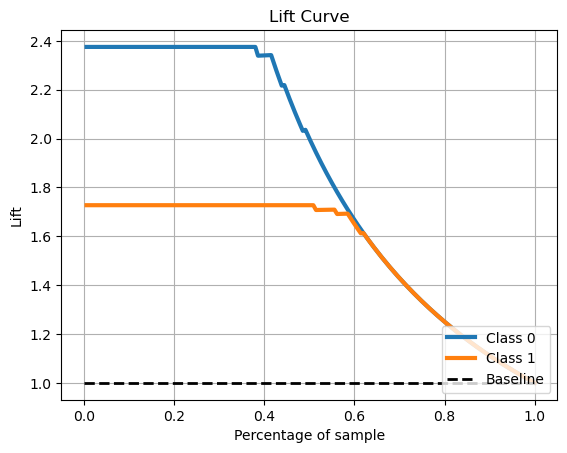

In [38]:
# AUC
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("The AUC is: ", auc)
print("The kappa stats is: ", cohen_kappa_score(y_test, y_pred))
print("The MCC stats is: ", matthews_corrcoef(y_test, y_pred))

# ROC curve
predicted_probas_lg = lg_grid.predict_proba(X_test_normalized)
skplt.metrics.plot_roc(y_test, predicted_probas_lg)

# Lift curve
skplt.metrics.plot_lift_curve(y_test, predicted_probas_lg)
plt.show()

## SVM

In [39]:
# Standardize the features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [40]:
# Tuning hyper-parameter
g = [0.001, 0.01, 0.1, 1, 10, 100] # gamma
c = [0.1, 1, 10, 100]
s_grid = dict(C = c, gamma = g )

# model
svm = SVC(probability = True)

# non-nested parameter search and scoring
svm_grid = GridSearchCV(svm, s_grid, cv=inner_cv, scoring='accuracy')

# train the model
svm_grid.fit(X_train_normalized, y_train)
y_pred = svm_grid.predict(X_test_normalized)

# nested CV with parameter opitimization
svm_score = cross_val_score(svm_grid,X=x,y=y, cv=outer_cv)

In [41]:
# Evaluate performance by cross-validation
svm_acc_scores = accuracy_score(y_test, y_pred)
svm_conf_mtrx = confusion_matrix(y_test, y_pred)
svm_cfr = classification_report(y_test, y_pred)


print('Predictive accuracy:', svm_acc_scores)
print('\n')
print('Confusion matrix: \n', svm_conf_mtrx)
print('\n')
print('Classification report:''\n', svm_cfr)

# aggregated performance metrics 
print("Mean of cross validation scores: ",svm_score.mean())
print("Standard Deviation of cross validation scores: ",svm_score.std())

Predictive accuracy: 0.9532163742690059


Confusion matrix: 
 [[64  8]
 [ 0 99]]


Classification report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94        72
           1       0.93      1.00      0.96        99

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.96      0.95      0.95       171

Mean of cross validation scores:  0.9208818506443098
Standard Deviation of cross validation scores:  0.016826089511704778


The AUC is:  0.9444444444444444
The kappa stats is:  0.9025641025641026
The MCC stats is:  0.9068792127632301


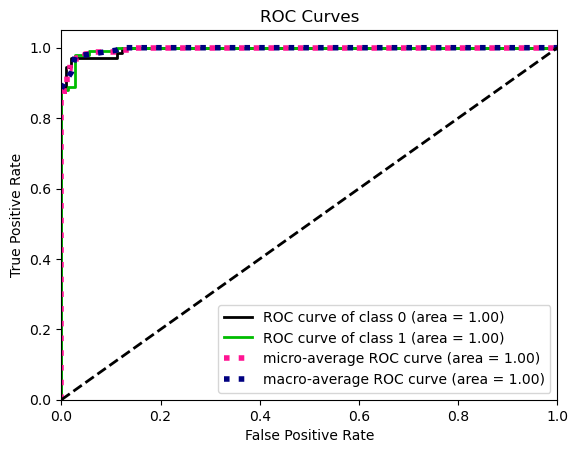

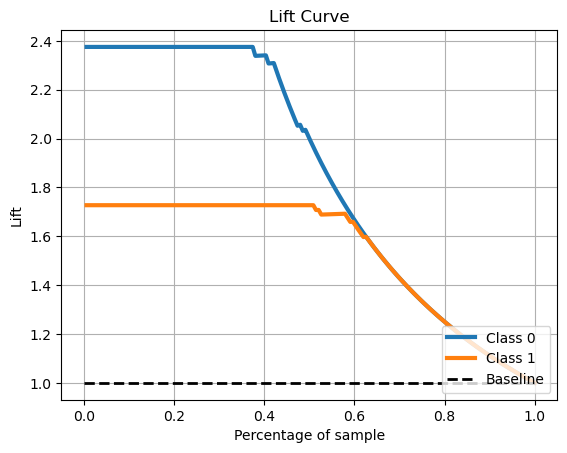

In [42]:
# AUC
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("The AUC is: ", auc)
print("The kappa stats is: ", cohen_kappa_score(y_test, y_pred))
print("The MCC stats is: ", matthews_corrcoef(y_test, y_pred))

# ROC curve
predicted_probas_svm = svm_grid.predict_proba(X_test_normalized)
skplt.metrics.plot_roc(y_test, predicted_probas_svm)

# Lift curve
skplt.metrics.plot_lift_curve(y_test, predicted_probas_svm)
plt.show()

## Models Selection

The Logistic Regression model stands out with the highest accuracy and strong performance across precision, recall, and F1-score for both classes. It appears to be a promising choice for this classification task.

In [43]:
print("Predictive accuracy")
print("Decision Tree: ", tree_acc_scores)
print("KNN: ",knn_acc_scores)
print("Logistic Regression: ",lg_acc_scores)
print("SVM: ",svm_acc_scores)

Predictive accuracy
Decision Tree:  0.9122807017543859
KNN:  0.9473684210526315
Logistic Regression:  0.9649122807017544
SVM:  0.9532163742690059
